In [1]:
pip install -q keras-nlp

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt
import os
from PIL import Image

In [6]:
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_train.csv')
img_folder = '/kaggle/input/memotion-dataset/Memotion 3/trainImages'
target_shape = (224, 224)
images = []

df['overall'] = df['overall'].replace({'negative': 0,'very_negative': 0,'neutral': 1,'positive': 2,'very_positive': 2})

for index, row in df.iterrows():
    if pd.isna(row['ocr']):
        df.at[index, 'ocr'] = '.'

#X_train_txt
X_train_txt = df['ocr']
X_train_txt = X_train_txt.tolist()
X_train_txt = [s.replace('\n', ' ') for s in X_train_txt]

#X_train_image
for index,row in df.iterrows():
    img_path = os.path.join(img_folder, str(row['image_id'])+'.jpg')
    image = Image.open(img_path)
    image = image.resize(target_shape)
    images.append(image)
    
X_train_img = np.array(images)

# Combine the columns into a new DataFrame
Y_train = df['overall']
Y_train = np.array(Y_train, dtype=np.int32)

/tmp/ipykernel_34/23834866.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['overall'] = df['overall'].replace({'negative': 0,'very_negative': 0,'neutral': 1,'positive': 2,'very_positive': 2})


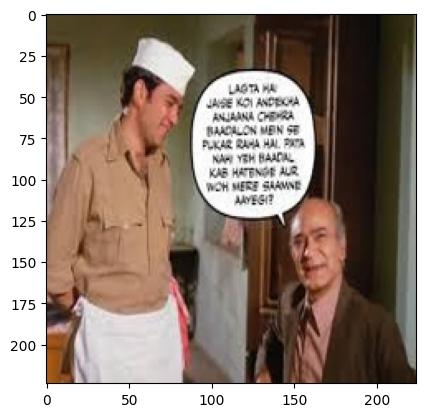

In [7]:
plt.imshow(X_train_img[2355])

In [8]:
X_train_txt[2355]

'LAGTA HA JAISE KOI ANDEKHA ANJAANA CHEHRA BAADALON MEIN SE PUKAR RAHA HAI PATA NAHI YEH BAADAL KAB HATENGE AUR WOH MERE SAAMNE AAYEGI?'

In [9]:
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_val.csv')
img_folder = '/kaggle/input/memotion-dataset/Memotion 3/valImages'
images = []

df['overall'] = df['overall'].replace({'negative': 0,'very_negative': 0,'neutral': 1,'positive': 2,'very_positive': 2})

for index, row in df.iterrows():
    if pd.isna(row['ocr']):
        df.at[index, 'ocr'] = '.'

#X_train_txt
X_val_txt = df['ocr']
X_val_txt = X_val_txt.tolist()
X_val_txt = [s.replace('\n', ' ') for s in X_val_txt]

#X_train_image
for index,row in df.iterrows():
    img_path = os.path.join(img_folder, str(row['image_id'])+'.jpg')
    image = Image.open(img_path)
    image = image.resize(target_shape)
    images.append(image)
    
X_val_img = np.array(images)

# Combine the columns into a new DataFrame
Y_val = df['overall']
Y_val = np.array(Y_val, dtype=np.int32)

/tmp/ipykernel_34/2688884826.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['overall'] = df['overall'].replace({'negative': 0,'very_negative': 0,'neutral': 1,'positive': 2,'very_positive': 2})


In [10]:
Y_train[:5]

array([1, 1, 2, 2, 0], dtype=int32)

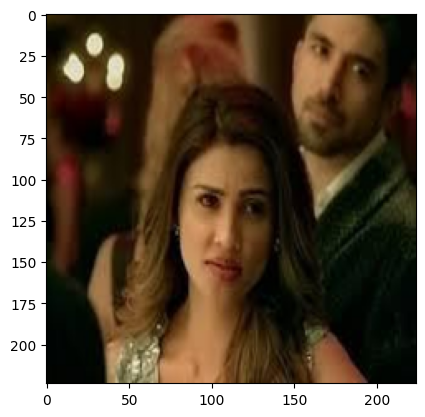

In [11]:
plt.imshow(X_val_img[715])

In [12]:
X_val_txt[715]

'.'

In [13]:
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

###  **Distil_BERT_Multi**

In [14]:
# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_multi",
    sequence_length=128,
)
# Pretrained classifier.
base_model_text = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_multi",
    num_classes=3,  
    preprocessor=preprocessor,
)

base_model_text.layers[-1].activation = keras.activations.sigmoid

# Access backbone programmatically
base_model_text.backbone.trainable = False

pooled_output = base_model_text.get_layer('pooled_dense').output

# Add a dense layer with 1024 neurons and sigmoid activation
txt_features = Dense(512, activation='relu')(pooled_output)

# Define the new model with the added layer
model_txt = Model(inputs=base_model_text.input, outputs=txt_features)


Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._func

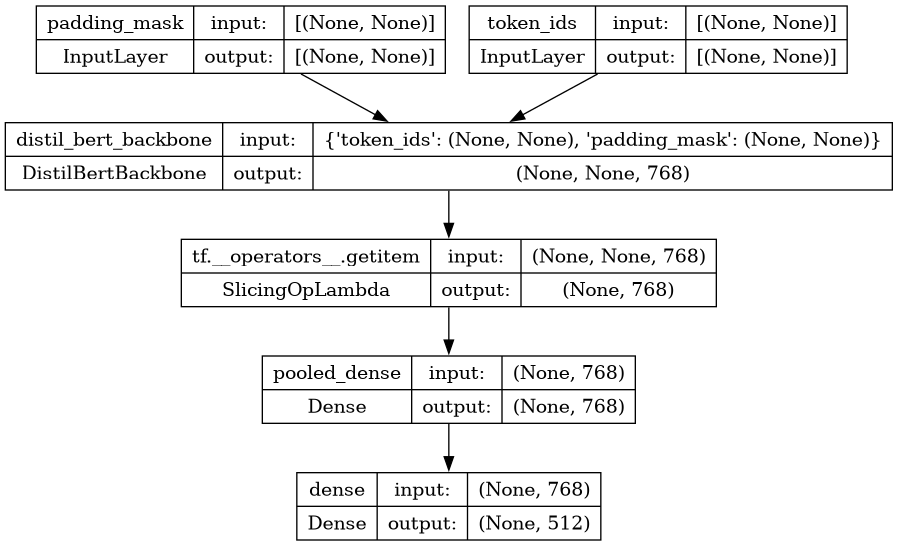

In [15]:
from keras.utils import plot_model
plot_model(model_txt, show_shapes=True, show_layer_names=True)

In [16]:
model_txt.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 padding_mask (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 token_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 distil_bert_backbone (Dist  (None, None, 768)            1347340   ['padding_mask[0][0]',        
 ilBertBackbone)                                          80         'token_ids[0][0]']           
                                                                                                  
 tf.__operators__.getitem (  (None, 768)                  0         ['distil_bert_backbone[0][

### **VGG16**

In [18]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, VGG16

# Load the pre-trained VGG16 model
base_model_img = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_img.output
x = Flatten()(x)
img_features = Dense(512, activation='relu')(x)
model_img = Model(inputs=base_model_img.input, outputs=img_features)

for layer in base_model_img.layers:
    layer.trainable = False


In [19]:
X_train_img = preprocess_input(X_train_img)
X_val_img = preprocess_input(X_val_img)

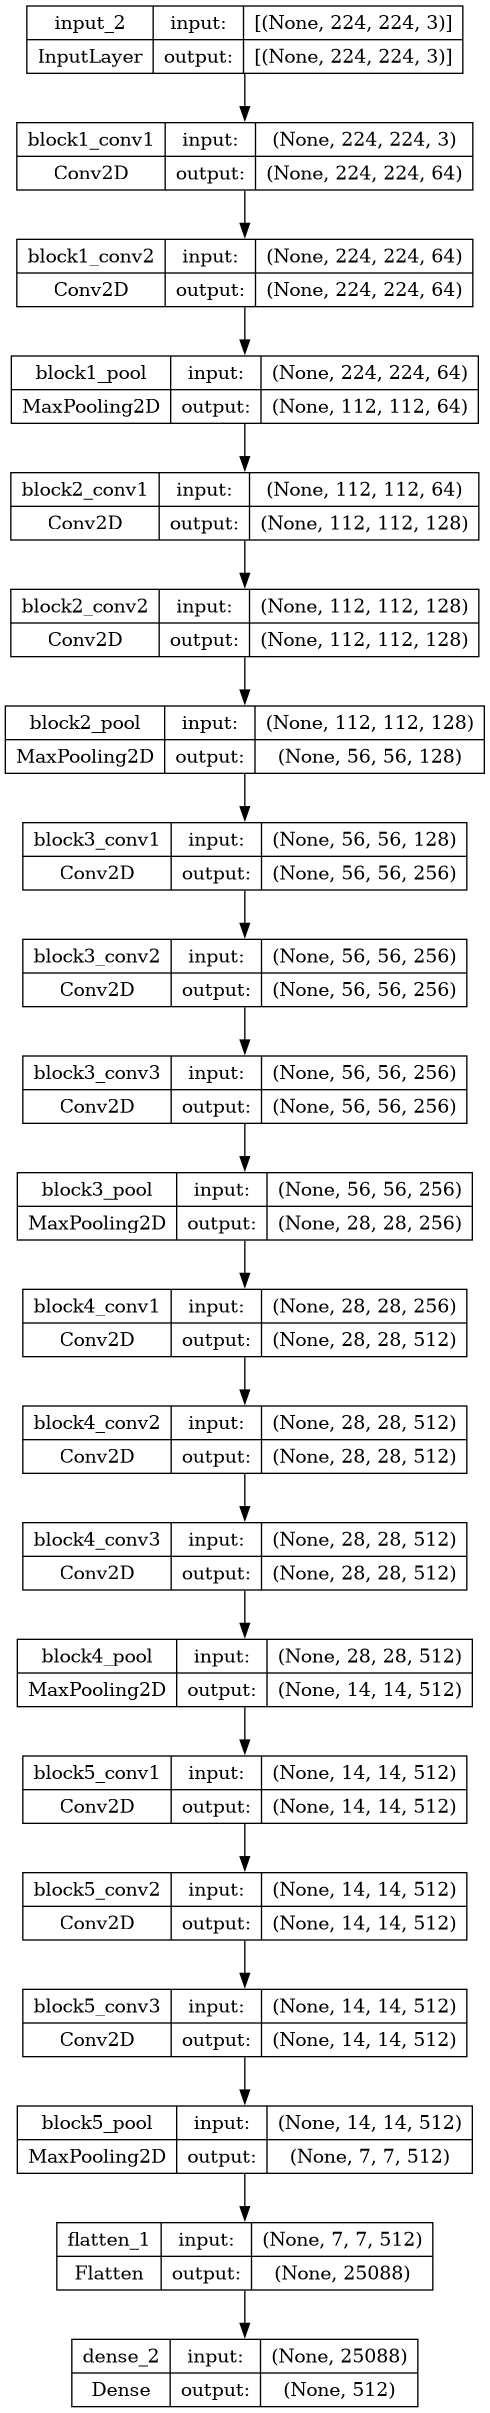

In [20]:
from keras.utils import plot_model
plot_model(model_img, show_shapes=True, show_layer_names=True)

In [21]:
# Define input layers
text_input = base_model_text.input
img_input = base_model_img.input

# Concatenate features
combined_features = keras.layers.concatenate([txt_features, img_features])

# Final prediction layer (adjust number of neurons based on your task)
predictions = keras.layers.Dense(3, activation='softmax')(combined_features)

# Create the final model
model = Model(inputs=[text_input, img_input], outputs=predictions)

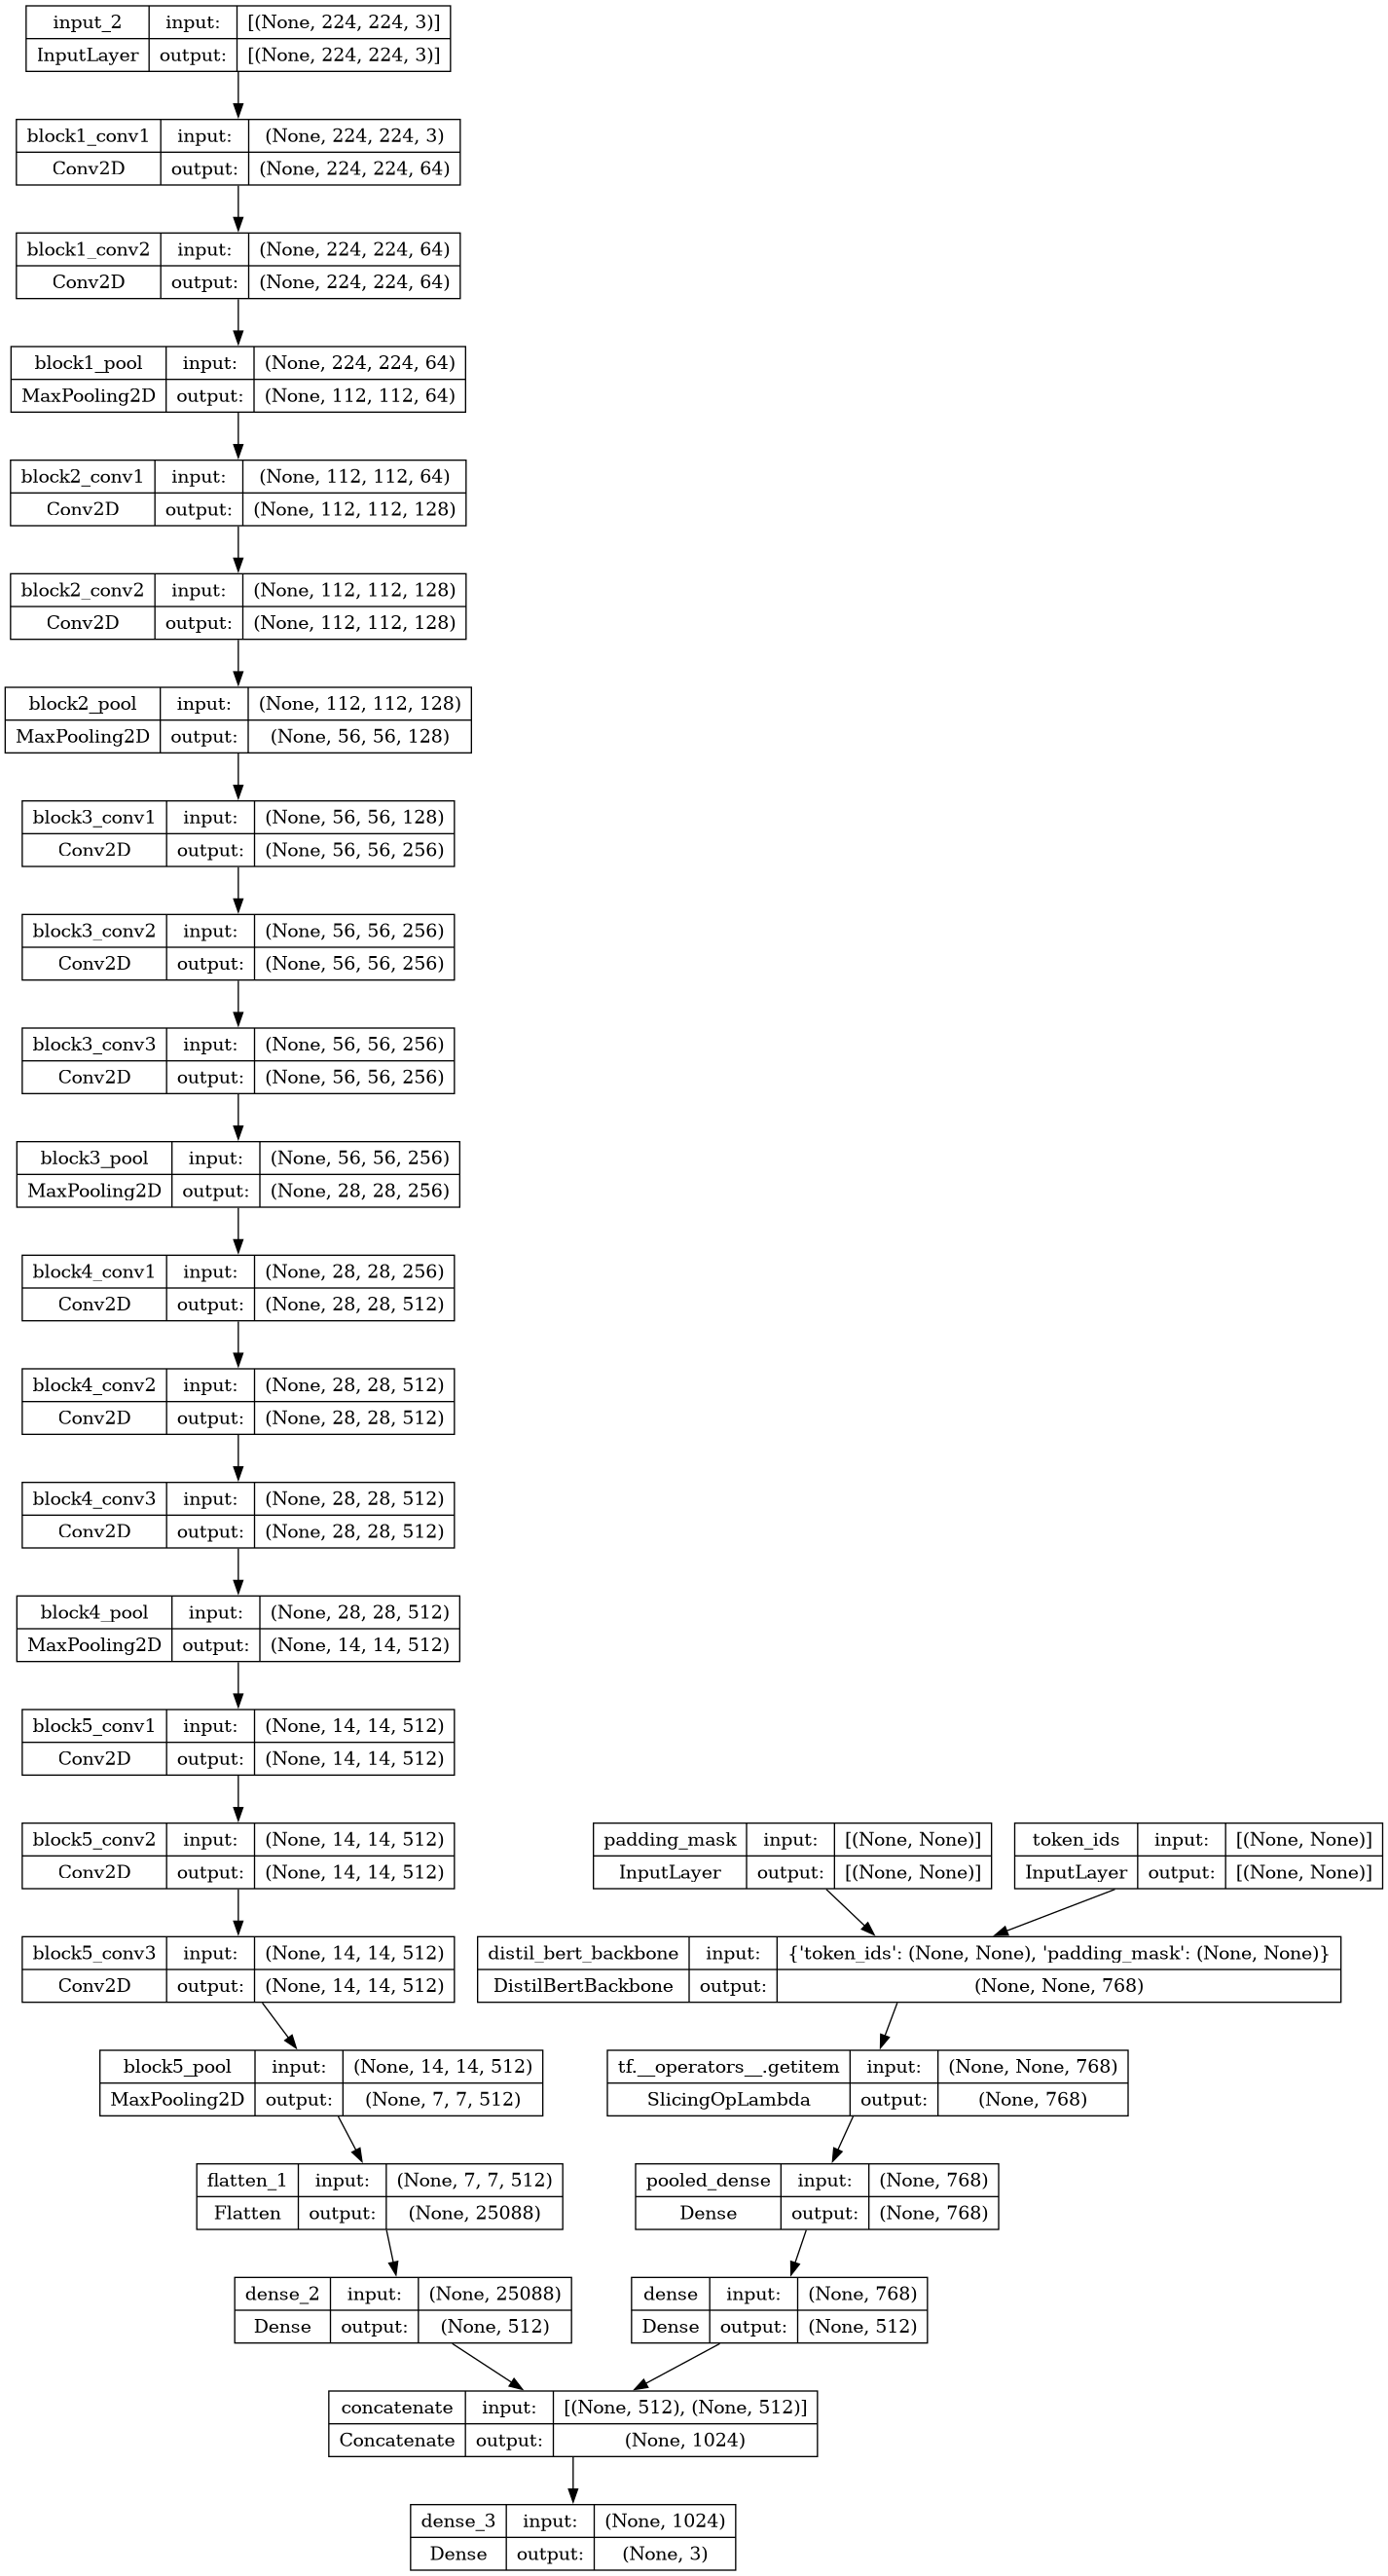

In [22]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
# Compile the model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=['accuracy']
             )

In [25]:
# Train the combined model
model.fit(
    x=[preprocessor(X_train_txt), X_train_img],  # Input data: text and image features
    y=Y_train,                      # Target data
    epochs=25,                      # Number of epochs
    batch_size=16,                  # Batch size
    validation_data=([preprocessor(X_val_txt), X_val_img], Y_val)
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1715255164.633252     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 [==============================] - 98s 190ms/step - loss: 2.2874 - accuracy: 0.4014 - val_loss: 1.1421 - val_accuracy: 0.3873
Epoch 2/25
438/438 [==============================] - 73s 166ms/step - loss: 1.0829 - accuracy: 0.4506 - val_loss: 1.1950 - val_accuracy: 0.3767
Epoch 3/25
438/438 [==============================] - 73s 166ms/step - loss: 1.0052 - accuracy: 0.4920 - val_loss: 1.2717 - val_accuracy: 0.3193
Epoch 4/25
438/438 [==============================] - 73s 166ms/step - loss: 0.8960 - accuracy: 0.5484 - val_loss: 1.2264 - val_accuracy: 0.3680
Epoch 5/25
438/438 [==============================] - 73s 166ms/step - loss: 0.7983 - accuracy: 0.5991 - val_loss: 1.3056 - val_accuracy: 0.3640
Epoch 6/25
438/438 [==============================] - 73s 166ms/step - loss: 0.7427 - accuracy: 0.6333 - val_loss: 1.3529 - val_accuracy: 0.3653
Epoch 7/25
438/438 [==============================] - 73s 166ms/step - loss: 0.6839 - accuracy: 0.6663 - val_loss: 1.5755 - val_accuracy: 0.3

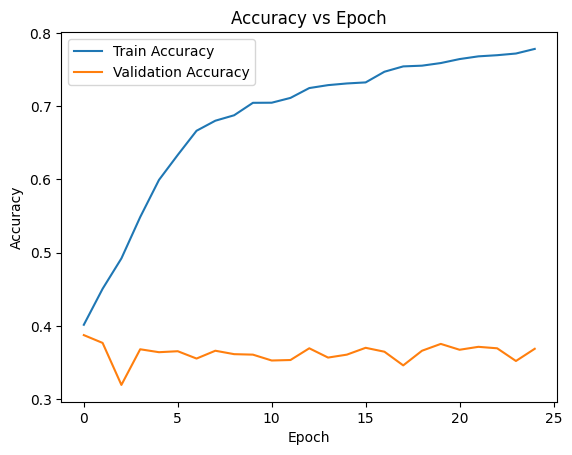

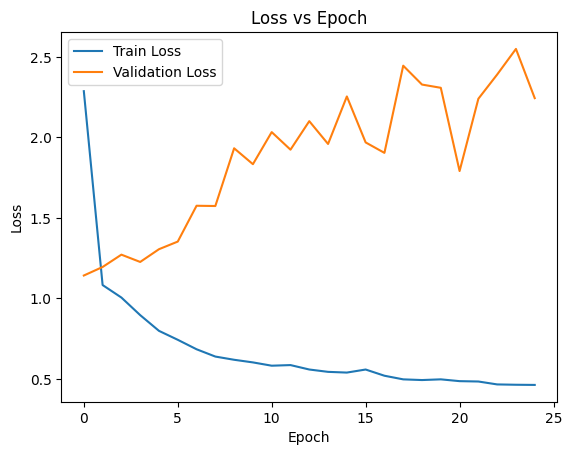

In [26]:
# Plot accuracy vs epoch
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss vs epoch
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
predicted = model.predict([preprocessor(X_val_txt),X_val_img])

47/47 [==============================] - 31s 439ms/step


In [28]:
predicted = np.argmax(predicted, axis=1)

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluate accuracy
accuracy = accuracy_score(Y_val, predicted)

# Calculate F1 score
f1 = f1_score(Y_val, predicted, average='weighted')

# Calculate precision
precision = precision_score(Y_val, predicted, average='weighted')

# Calculate recall
recall = recall_score(Y_val, predicted, average='weighted')

print("Score of Meme overall sentiment Detection")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Score of Meme overall sentiment Detection
Accuracy: 0.36866666666666664
F1 Score: 0.3562656972387103
Precision: 0.3548495837595405
Recall: 0.36866666666666664
